![](../images/data_augmentation.png)

## Introduction

In this notebook, you'll tackle **image classification** using **Convolutional Neural Networks (CNNs)**. As demonstrated in lectures, there's a fundamental principle in deep learning: **deeper networks typically possess greater model capacity**. However, this increased capacity often leads to a higher risk of **overfitting**, as the number of learnable parameters escalates significantly.

### The Role of Data Augmentation

In CNNs, **Data Augmentation** emerges as a crucial technique to bolster the model's robustness against overfitting. By applying transformations such as:

- **Rotation** (random angles)
- **Shifting** (horizontal and vertical translation)
- **Flipping** (horizontal/vertical mirroring)
- **Zooming** (scaling in/out)
- **Shearing** (slanting transformations)

Data Augmentation artificially **diversifies the training dataset**, helping the model generalize better to unseen data. Widely embraced since its introduction in **AlexNet (2012)**, Data Augmentation has become a cornerstone technique in modern computer vision.

### About ImageDataGenerator

`ImageDataGenerator` is a powerful utility class within the Keras library, facilitating:
- **Image preprocessing** (rescaling, normalization)
- **Real-time data augmentation** during model training
- **Efficient batch loading** from disk

It's primarily employed in tasks like image classification, object detection, and image segmentation.

**Directory Structure Requirements:**

To leverage `ImageDataGenerator` effectively, organize your image data into separate directories, each representing a distinct class:

![Directory Structure](https://expoundai.files.wordpress.com/2019/04/directorystructure.png)

### What You'll Do

In this assignment, you'll:

1. **Build a CNN with data augmentation** and evaluate its performance
2. **Train the same model WITHOUT augmentation** to observe overfitting

This comparison will clearly illustrate the effectiveness of data augmentation in mitigating overfitting.

Let's get started!

## Setup: Import Required Libraries

First, import the necessary libraries for image processing, model building, and visualization.

In [2]:
import os
os.environ["KERAS_BACKEND"] = "torch"

import zipfile
import random
import shutil
import keras
#this doesn't work
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import image_dataset_from_directory
from shutil import copyfile
import matplotlib.pyplot as plt
import numpy as np

print(f"Keras version: {keras.__version__}")
print(f"Using backend: {keras.backend.backend()}")

Keras version: 3.12.0
Using backend: tensorflow


### Check Device Availability

Let's verify whether GPU acceleration is available for faster training:

In [3]:
# Check for GPU availability
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"✓ GPU available: {torch.cuda.get_device_name(0)}")
    print(f"  Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    print("  Training will be significantly faster on GPU!")
else:
    device = torch.device("cpu")
    print("⚠ No GPU detected - using CPU")
    print("  Training will be slower. Consider using Google Colab or Kaggle Kernel for free GPU access.")

⚠ No GPU detected - using CPU
  Training will be slower. Consider using Google Colab or Kaggle Kernel for free GPU access.


## Step 1: Load the 10-Flowers Dataset

Load the dataset, which contains images of **10 different flower species** organized into subfolders. Each subfolder represents a different flower class (labeled 0-9).

In [4]:

local_zip = '10flows.zip'

if not os.path.exists(local_zip):
    print("Please copy the 10flows.zip file to the current directory")
else:
    zip_ref   = zipfile.ZipFile(local_zip, 'r')
    zip_ref.extractall('.')
    zip_ref.close()

### Dataset Overview

Let's examine the **class distribution** — the number of images for each flower class:

In [5]:
source_path = 'flowers'

for label in range(10):
    print(f"There are {len(os.listdir(os.path.join(source_path, str(label))))} images of {label}.")

There are 137 images of 0.
There are 137 images of 1.
There are 137 images of 2.
There are 137 images of 3.
There are 137 images of 4.
There are 137 images of 5.
There are 137 images of 6.
There are 137 images of 7.
There are 137 images of 8.
There are 137 images of 9.


### Visual Exploration

Display **5 random sample images** from each of the 10 flower classes to get a sense of the dataset's diversity:

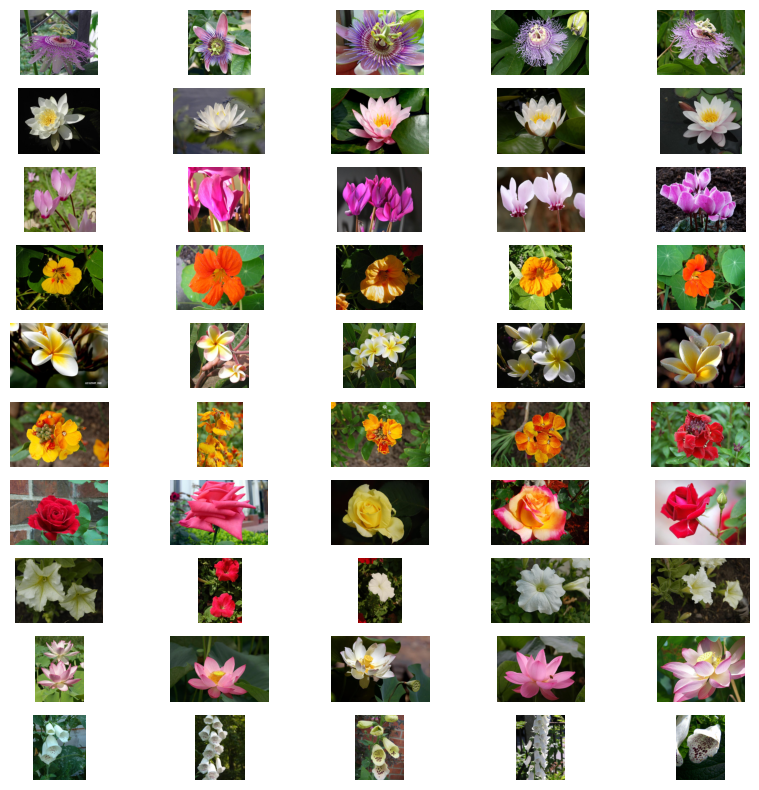

In [6]:
# show 5 random images from each class in a 10x5 grid
fig = plt.figure(figsize=(10, 10))
for i in range(10):
    for j in range(5):
        img = plt.imread(f'flowers/{i}/{random.choice(os.listdir(f"flowers/{i}"))}')
        fig.add_subplot(10, 5, i*5+j+1)
        plt.axis('off')
        plt.imshow(img)

In [7]:
# print out the size of each image
img = plt.imread(f'flowers/0/{random.choice(os.listdir("flowers/0"))}')
print(f"Image size: {img.shape}")

Image size: (500, 667, 3)


## Step 2: Split Dataset into Training, Validation, and Test Sets

We'll organize the data into a directory structure compatible with Keras' `ImageDataGenerator`.

**Split Ratios:**
- **Training**: 70% (for learning patterns)
- **Validation**: 20% (for hyperparameter tuning and monitoring)
- **Test**: 10% (for final evaluation)

You don't need to modify anything in this step — just run the code to create the proper directory structure.

In [8]:
# Define root directory
root_dir = 'sandbox'

# Empty directory to prevent FileExistsError is the function is run several times
if os.path.exists(root_dir):
  shutil.rmtree(root_dir)

def create_train_val_dirs(root_path):
  """
  Creates directories for the train and test sets

  Args:
    root_path (string) - the base directory path to create subdirectories from

  Returns:
    None
  """
  for name in range(10):
    for name2 in ['training','validation','test']:
      os.makedirs(os.path.join(root_path,name2,str(name)))

try:
  create_train_val_dirs(root_path=root_dir)
except FileExistsError:
  print("You should not be seeing this since the upper directory is removed beforehand")

In [9]:
for rootdir, dirs, files in os.walk(root_dir):
    for subdir in dirs:
        print(os.path.join(rootdir, subdir))

sandbox/test
sandbox/training
sandbox/validation
sandbox/test/9
sandbox/test/0
sandbox/test/7
sandbox/test/6
sandbox/test/1
sandbox/test/8
sandbox/test/4
sandbox/test/3
sandbox/test/2
sandbox/test/5
sandbox/training/9
sandbox/training/0
sandbox/training/7
sandbox/training/6
sandbox/training/1
sandbox/training/8
sandbox/training/4
sandbox/training/3
sandbox/training/2
sandbox/training/5
sandbox/validation/9
sandbox/validation/0
sandbox/validation/7
sandbox/validation/6
sandbox/validation/1
sandbox/validation/8
sandbox/validation/4
sandbox/validation/3
sandbox/validation/2
sandbox/validation/5


In [10]:
def split_data(SOURCE_DIR, TRAINING_DIR, VALIDATION_DIR, TEST_DIR, TRAIN_SPLIT, VAL_SPLIT):
    """
    Splits the data into train, validation, and test sets.

    Args:
        SOURCE_DIR (string): directory path containing the images
        TRAINING_DIR (string): directory path to be used for training
        VALIDATION_DIR (string): directory path to be used for validation
        TEST_DIR (string): directory path to be used for testing
        TRAIN_SPLIT (float): proportion of the dataset to be used for training
        VAL_SPLIT (float): proportion of the dataset to be used for validation
    """

    np.random.seed(42)
    files = []
    for name in os.listdir(SOURCE_DIR):
        if os.path.getsize(os.path.join(SOURCE_DIR, name)) > 0:
            files.append(name)
    random.shuffle(files)

    train_size = int(len(files) * TRAIN_SPLIT)
    val_size = int(len(files) * VAL_SPLIT)

    for name in files[:train_size]:
        shutil.copy(os.path.join(SOURCE_DIR, name), os.path.join(TRAINING_DIR, name))
    for name in files[train_size:train_size + val_size]:
        shutil.copy(os.path.join(SOURCE_DIR, name), os.path.join(VALIDATION_DIR, name))
    for name in files[train_size + val_size:]:
        shutil.copy(os.path.join(SOURCE_DIR, name), os.path.join(TEST_DIR, name))

### Execute the Data Split

Run the cell below to split the dataset and verify the distribution across training, validation, and test sets:

In [11]:
TRAINING_DIR = "sandbox/training/"
VALIDATION_DIR = "sandbox/validation/"
TEST_DIR = "sandbox/test/"

# Empty directories in case you run this cell multiple times
for i in range(10):
  label_train_dir = os.path.join(TRAINING_DIR, str(i))
  label_val_dir = os.path.join(VALIDATION_DIR, str(i))
  label_test_dir = os.path.join(TEST_DIR, str(i))
  if len(os.listdir(label_train_dir)) > 0:
    for file in os.scandir(label_train_dir):
      os.remove(file.path)
  if len(os.listdir(label_val_dir)) > 0:
    for file in os.scandir(label_val_dir):
      os.remove(file.path)
  if len(os.listdir(label_test_dir)) > 0:
    for file in os.scandir(label_test_dir):
      os.remove(file.path)

# Define proportion of images used for training and validation
train_split = 0.7
val_split = 0.2
test_split = 0.1

# Run the function
for i in range(10):
  label_train_dir = os.path.join(TRAINING_DIR, str(i))
  label_val_dir = os.path.join(VALIDATION_DIR, str(i))
  label_test_dir = os.path.join(TEST_DIR, str(i))
  split_data(SOURCE_DIR=os.path.join(source_path, str(i)),
             TRAINING_DIR=label_train_dir,
             VALIDATION_DIR=label_val_dir,
             TEST_DIR=label_test_dir,
             TRAIN_SPLIT=train_split,
             VAL_SPLIT=val_split)

# Check that the number of images matches the expected output
for i in range(10):
  print(f"There are {len(os.listdir(os.path.join(TRAINING_DIR, str(i))))} images of {i} in the training set")
  print(f"There are {len(os.listdir(os.path.join(VALIDATION_DIR, str(i))))} images of {i} in the validation set")
  print(f"There are {len(os.listdir(os.path.join(TEST_DIR, str(i))))} images of {i} in the test set")


There are 95 images of 0 in the training set
There are 27 images of 0 in the validation set
There are 15 images of 0 in the test set
There are 95 images of 1 in the training set
There are 27 images of 1 in the validation set
There are 15 images of 1 in the test set
There are 95 images of 2 in the training set
There are 27 images of 2 in the validation set
There are 15 images of 2 in the test set
There are 95 images of 3 in the training set
There are 27 images of 3 in the validation set
There are 15 images of 3 in the test set
There are 95 images of 4 in the training set
There are 27 images of 4 in the validation set
There are 15 images of 4 in the test set
There are 95 images of 5 in the training set
There are 27 images of 5 in the validation set
There are 15 images of 5 in the test set
There are 95 images of 6 in the training set
There are 27 images of 6 in the validation set
There are 15 images of 6 in the test set
There are 95 images of 7 in the training set
There are 27 images of 7

## Step 3: Create Data Generators with Augmentation

Now that you've organized the data properly, it's time to create **data generators** that will:

1. **Load images in batches** (memory efficient)
2. **Apply real-time augmentation** during training
3. **Standardize image sizes** to a consistent resolution

### Key Parameters:

- **`target_size=(224, 224)`**: Resizes all images to 224×224 pixels (standard for many CNN architectures)
- **`class_mode='sparse'`**: Uses integer labels (0-9) instead of one-hot encoding
- **`rescale=1./255`**: Normalizes pixel values from [0, 255] to [0, 1]

### Data Augmentation Transformations (Training Only):

- `rotation_range=40`: Random rotations up to ±40°
- `width_shift_range=0.2`: Random horizontal shifts (20% of width)
- `height_shift_range=0.2`: Random vertical shifts (20% of height)
- `shear_range=0.2`: Random shearing transformations
- `zoom_range=0.2`: Random zoom in/out (80%-120%)
- `horizontal_flip=True`: Random horizontal flipping
- `fill_mode='nearest'`: Fill strategy for pixels outside boundaries

**Note:** Validation and test sets only receive rescaling (no augmentation) to ensure consistent evaluation.

Run the cell below to create the generators:

In [12]:

def train_val_generators(TRAINING_DIR, VALIDATION_DIR, TEST_DIR):
  """
  Creates the training and validation data generators

  Args:
    TRAINING_DIR (string): directory path containing the training images
    VALIDATION_DIR (string): directory path containing the testing/validation images

  Returns:
    train_generator, validation_generator - tuple containing the generators
  """
  ### START CODE HERE

  # Instantiate the ImageDataGenerator class for the training set
  train_datagen = ImageDataGenerator(rescale=1./255,
                                     rotation_range=40,
                                      width_shift_range=0.2,
                                      height_shift_range=0.2,
                                      shear_range=0.2,
                                      zoom_range=0.2,
                                      horizontal_flip=True,
                                      fill_mode='nearest')
  # only applying the rescale transformation to the validation and test sets
  val_test_datagen = ImageDataGenerator(rescale=1./255)

  # Pass in the appropriate arguments to the flow_from_directory method
  train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=32,
                                                      class_mode='sparse',
                                                      target_size=(224, 224))
  validation_generator = val_test_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                              batch_size=32,
                                                              class_mode='sparse',
                                                              target_size=(224, 224))
  test_generator = val_test_datagen.flow_from_directory(directory=TEST_DIR,
                                                        batch_size=32,
                                                        class_mode='sparse',
                                                        target_size=(224, 224))
  return train_generator, validation_generator, test_generator


In [13]:
# Test your generators
train_generator, validation_generator, test_generator = train_val_generators(TRAINING_DIR, VALIDATION_DIR, TEST_DIR)

Found 950 images belonging to 10 classes.
Found 270 images belonging to 10 classes.
Found 150 images belonging to 10 classes.


## Task 1: Design Your CNN Architecture

**Objective:** Build a CNN model that achieves strong performance on the flower classification task.

To pass this task, your model should:

✅ **Test Accuracy**: ≥ 80% with `epochs` = 20.  

In [36]:
# GRADED FUNCTION: create_model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Activation, Add, Dropout

def create_model():
  """
  Creates a CNN model for flower classification.

  Architecture:
    - 4 Convolutional blocks with progressive filter increase (32→64→128→128)
    - MaxPooling after each conv block for dimensionality reduction
    - Dense layer with 512 units for high-level feature learning
    - Output layer with 10 units (softmax) for 10-class classification

  Returns:
    Compiled Keras model ready for training
  """

  model = keras.models.Sequential([

    # start building the model here
    Conv2D(32, (3,3), activation= 'relu', padding = 'same', input_shape = (224, 224, 3)),
    MaxPooling2D((2,2)),

    Conv2D(64, (3,3), activation = 'relu', padding = 'same'),
    MaxPooling2D((2,2)),

    Conv2D(128, (3,3), activation = 'relu', padding = 'same'),
    MaxPooling2D((2,2)),

    Conv2D(128, (3,3), activation = 'relu', padding = 'same'),
    MaxPooling2D((2,2)),

    Flatten(),
    Dense(512, activation = 'relu'),
    Dropout(0.5),
    Dense(10, activation = 'softmax')
    # end building the model here
  ])


  # Compile with appropriate loss for multi-class classification
  model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

  return model


In [37]:
# create the untrained model
model = create_model()

# Display model architecture
model.summary()

# Count parameters
print('Number of parameters:', model.count_params())

# Train the model
history = model.fit(train_generator, validation_data = validation_generator, epochs = 20)

/Users/ltan/Documents/STAT 362-0/stat362-1/.venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_32 (Conv2D)              │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_32 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_33 (MaxPooling2D) │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_34 (MaxPooling2D) │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 28, 28, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_35 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,091,530 (49.94 MB)

 Trainable params: 13,091,530 (49.94 MB)

 Non-trainable params: 0 (0.00 B)

Number of parameters: 13091530
Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 211ms/step - accuracy: 0.1905 - loss: 2.1996 - val_accuracy: 0.3333 - val_loss: 1.7938
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 187ms/step - accuracy: 0.2853 - loss: 1.8781 - val_accuracy: 0.4111 - val_loss: 1.6099
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 180ms/step - accuracy: 0.3432 - loss: 1.7274 - val_accuracy: 0.4556 - val_loss: 1.4000
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 184ms/step - accuracy: 0.3926 - loss: 1.6097 - val_accuracy: 0.5741 - val_loss: 1.2625
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 180ms/step - accuracy: 0.4453 - loss: 1.4992 - val_accuracy: 0.4778 - val_loss: 1.2548
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 181ms/step - accuracy: 0.4726 - loss: 1.4388 - val_accuracy: 0.5185 - val_loss: 1.4147
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 185ms/step - accuracy: 0.5200 - loss: 1.3450 - val_accuracy: 0.6185 - val_loss: 1.3316
Epoch 8/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 181ms/step - accuracy: 0.5474 - 

### Visualize Training Progress

Once training has finished, visualize the **training and validation metrics** across epochs.



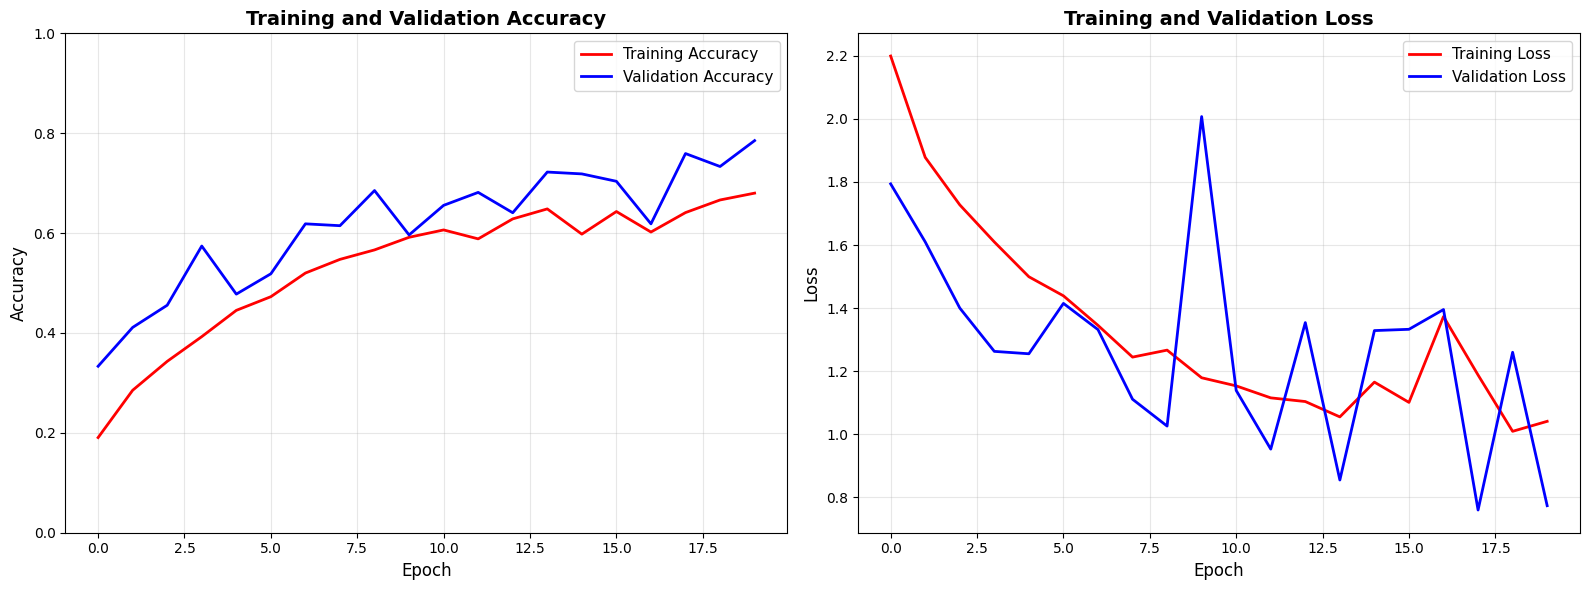


  Training Summary
  Best Training Accuracy:   0.6800 (epoch 20)
  Best Validation Accuracy: 0.7852 (epoch 20)
  Final Training Accuracy:  0.6800
  Final Validation Accuracy:0.7852
  Accuracy Gap (final):     0.1052


In [38]:
# Extract training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Accuracy
ax1.plot(epochs_range, acc, 'r-', linewidth=2, label="Training Accuracy")
ax1.plot(epochs_range, val_acc, 'b-', linewidth=2, label="Validation Accuracy")
ax1.set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)
ax1.set_ylim([0, 1])

# Plot 2: Loss
ax2.plot(epochs_range, loss, 'r-', linewidth=2, label="Training Loss")
ax2.plot(epochs_range, val_loss, 'b-', linewidth=2, label="Validation Loss")
ax2.set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"\n{'='*60}")
print(f"  Training Summary")
print(f"{'='*60}")
print(f"  Best Training Accuracy:   {max(acc):.4f} (epoch {acc.index(max(acc))+1})")
print(f"  Best Validation Accuracy: {max(val_acc):.4f} (epoch {val_acc.index(max(val_acc))+1})")
print(f"  Final Training Accuracy:  {acc[-1]:.4f}")
print(f"  Final Validation Accuracy:{val_acc[-1]:.4f}")
print(f"  Accuracy Gap (final):     {abs(acc[-1] - val_acc[-1]):.4f}")
print(f"{'='*60}")

In addition to reporting your training and validation accuracy above, please also include your test accuracy below. Finally, comment on whether your model shows signs of overfitting.

In [39]:
# Evaluate on test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test loss: {test_loss:.4f}")
print(f"Test accuracy: {test_accuracy:.4f}")


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.8133 - loss: 0.5150
Test loss: 0.5150
Test accuracy: 0.8133


The validation and test accuracy are within 0.03 of each other, making it clear that the model is not overfitting, especially since the test accuracy is high despite the training accuracy being relatively lower.

## ⭐ Bonus Challenge: Achieve Test Accuracy Above 85%

This task is **optional** — you may skip it if you prefer.

If your model reaches **> 85% test accuracy**, you will earn **1 bonus point**(added to your total score) at the end!

Feel free to experiment with:

- Different model architectures
- Optimizers & learning rate schedules
- Regularization (dropout, batch norm, early stopping, etc.)

## Task 2: Experience Overfitting Without Data Augmentation

Simply train the same model architecture **WITHOUT data augmentation** to observe the overfitting phenomenon.

In [40]:
def load_images_and_labels(directory):
    images = []
    labels = []
    for label, class_name in enumerate(os.listdir(directory)):
        class_dir = os.path.join(directory, class_name)
        for image_name in os.listdir(class_dir):
            image = keras.preprocessing.image.load_img(
                os.path.join(class_dir, image_name),
                target_size=(224, 224)
            )
            image = keras.preprocessing.image.img_to_array(image)
            images.append(image)
            labels.append(label)
    return np.array(images), np.array(labels)

In [41]:
# Load images and labels
images, labels = load_images_and_labels('flowers')

In [42]:
from sklearn.model_selection import train_test_split
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.1, random_state=42)

In [43]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1233, 224, 224, 3), (137, 224, 224, 3), (1233,), (137,))

In [44]:
# Get the untrained model
model2 = create_model()

# IMPORTANT: Normalize the training data (divide by 255)
X_train_normalized = X_train / 255.0
X_test_normalized = X_test / 255.0

# Train the model (without data augmentation)
history_2 = model2.fit(
    X_train_normalized,
    y_train,
    epochs=20,
    verbose=1
)

Epoch 1/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 9s 189ms/step - accuracy: 0.2311 - loss: 2.1543
Epoch 2/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 180ms/step - accuracy: 0.4420 - loss: 1.5469
Epoch 3/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 188ms/step - accuracy: 0.5085 - loss: 1.3898
Epoch 4/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 8s 206ms/step - accuracy: 0.6115 - loss: 1.1384
Epoch 5/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 178ms/step - accuracy: 0.6837 - loss: 0.9579
Epoch 6/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 175ms/step - accuracy: 0.7510 - loss: 0.8215
Epoch 7/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 170ms/step - accuracy: 0.7826 - loss: 0.7687
Epoch 8/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 175ms/step - accuracy: 0.8167 - loss: 0.7063
Epoch 9/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 179ms/step - accuracy: 0.8459 - loss: 0.8606
Epoch 10/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 170ms/step - accuracy: 0.8840 - loss: 0.4361
Epoch 11/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 169ms/step - accuracy: 0.8556 - loss: 0.8479
Epoch 12/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 169ms/step

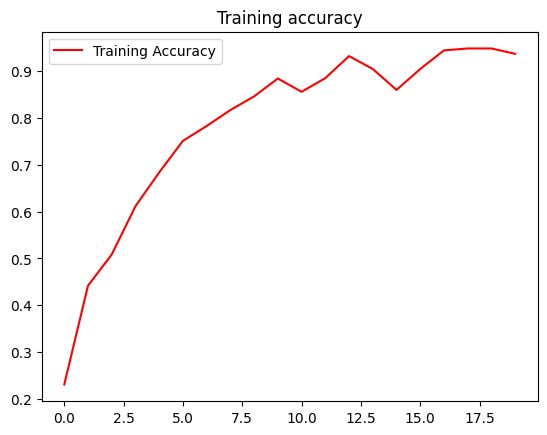

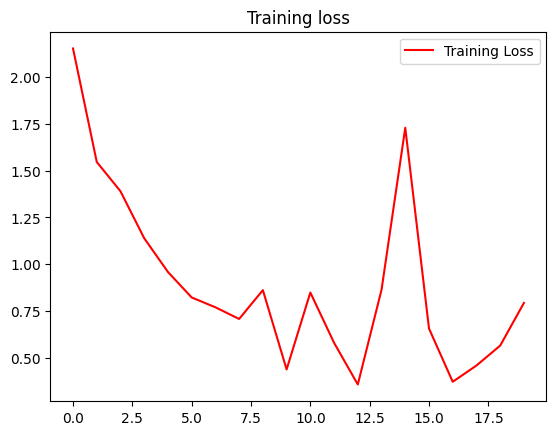

In [45]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history_2.history['accuracy']
loss=history_2.history['loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', label="Training Accuracy")
plt.title('Training accuracy')
plt.legend()
plt.show()
print("")

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', label="Training Loss")
plt.title('Training loss')
plt.legend()
plt.show()

In [46]:
# Evaluate the model on test set
test_loss, test_accuracy = model2.evaluate(X_test_normalized, y_test, verbose=0)

# Print results
print(f"\n{'='*50}")
print(f"  Final Training Accuracy: {history_2.history['accuracy'][-1]:.4f}")
print(f"  Final Test Accuracy:     {test_accuracy:.4f}")
print(f"  Accuracy Gap:            {abs(history_2.history['accuracy'][-1] - test_accuracy):.4f}")
print(f"{'='*50}")

if abs(history_2.history['accuracy'][-1] - test_accuracy) > 0.15:
    print("\n⚠️  OVERFITTING DETECTED!")
    print("   Training accuracy is much higher than test accuracy.")
    print("   This is why data augmentation is important!")
else:
    print("\n✓ Model generalizes well (minimal overfitting)")


  Final Training Accuracy: 0.9367
  Final Test Accuracy:     0.6496
  Accuracy Gap:            0.2871

⚠️  OVERFITTING DETECTED!
   Training accuracy is much higher than test accuracy.
   This is why data augmentation is important!


## Task 3: Summarize what you have learned from this notebook below.

I have learned that data augmentation is a useful technique make the model more robust against overfitting as you artificially diversifies the training dataset, helping the model generalize better to unseen data.

This is why in our implementation without the augmenation, we saw a much better performance in the training accuracy with a very drastic worse performance in test.